In [1]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:95% !important;} </style>"))

%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import pandas as pd
import numpy as np
import shlex
from io import StringIO

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl

In [3]:
import sys
sys.path.append("../")
from pyelegant.ElegantRun import ElegantRun
from pyelegant.SDDSTools.SDDS import SDDS, SDDSCommand
from pyelegant.SDDSTools.Utils import GenerateNDimCoordinateGrid

In [5]:
from cpymad.madx import Madx
# import pysixtrack
# import sixtracklib as stl

In [6]:
sif = "/home/mti/gitlab-hzb/containers/bin/pelegant.sif"

# Reproduce FODO

## Symplectic FODO

In [23]:
elements ={
    "QF":{
        "type" : "KQUAD",
        "L": 0.342,
        "K1": 0.49,
        "N_KICKS":16
    },
    "QD":{
        "type" : "KQUAD",
        "L": 0.668,
        "K1": -0.4999,
        "N_KICKS":16
    },
    "D":{
        "type" : "DRIF",
     "L":3.5805   
    },
    "W1": {
        "type": "WATCH",
        "filename":"\"%s-%03ld.w1\"",
        "mode": "coordinates"
    }
}

FODOstr = "! FODO cell used by Jernej Frank for studying TRIBs\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line = ["W1","QF","D","QD","D","QF"]
linestr = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

In [24]:
print(FODOstr)

! FODO cell used by Jernej Frank for studying TRIBs

QF    : KQUAD, L= 0.342000000000, K1= 0.490000000000, N_KICKS=16.000000000000
QD    : KQUAD, L= 0.668000000000, K1=-0.499900000000, N_KICKS=16.000000000000
D     : DRIF, L= 3.580500000000
W1    : WATCH, filename="%s-%03ld.w1", mode=coordinates

FODO  : LINE=(W1,QF,D,QD,D,QF)


In [25]:
with open("FODO_Jernej.lte","w") as f:
    f.write(FODOstr)

## Non-symplectic FODO

In [9]:
elements ={
    "QF":{
        "type" : "QUAD",
        "L": 0.342,
        "K1": 0.49,
#         "N_KICKS":16
    },
    "QD":{
        "type" : "QUAD",
        "L": 0.668,
        "K1": -0.4999,
#         "N_KICKS":16
    },
    "D":{
        "type" : "DRIF",
     "L":3.5805   
    },
    "W1": {
        "type": "WATCH",
        "filename":"\"%s-%03ld.w1\"",
        "mode": "coordinates"
    }
}

FODOstr = "! FODO cell used by Jernej Frank for studying TRIBs\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line = ["W1","QF","D","QD","D","QF"]
linestr = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += "\n".join(stringlist)
FODOstr += "\n\n"
FODOstr += linestr

In [10]:
with open("FODO_Jernej_non_symplectic.lte","w") as f:
    f.write(FODOstr)

# Non-Symplectic Tracking

In [13]:
lattice = "FODO_Jernej_non_symplectic.lte"

er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
twidata, twipar = er.findtwiss()

# off - momentum
delta = 1.5e-3 * twipar.pCentral

# coordinate grid
man_ranges= {
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05], #0.05
    2 : 0,#[.001,0.01,0.1,1,1.95,2],
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

# generate coordinate input file
er.generate_sdds_particle_inputfile(man_ranges=man_ranges)

# track
er.track_simple(n_passes=2000)

Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele


In [14]:
# quick plot
sddsp = SDDS(sif,"temp-001.w1",0)

sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="-2.5,2.5,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
#     device="gif",
#     output="FODO_island_init_px_non_zero_non_symplectic.gif"
)


Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=-2.5,2.5,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID


# Symplectic case

In [29]:
lattice = "FODO_Jernej.lte"

er = ElegantRun(sif,lattice, parallel=True, use_beamline="FODO", energy=1700.00)
twidata, twipar = er.findtwiss()


# off - momentum
delta = 1.5e-3 * twipar.pCentral


# coordinate grid around islands
man_ranges= {
#     0 : np.linspace(1.7,2.0,100),
    0 : np.array([0,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.95,1.975,1.9875,2,2.1,2.2,2.3]),
    1 : [0.05], #0.05
    2 : 0,#[.001,0.01,0.1,1,1.95,2],
    3 : 0,
    4 : 0,
    5 : twipar.pCentral + delta 
}

er.generate_sdds_particle_inputfile(man_ranges=man_ranges)

# track
er.track_simple(n_passes=2000)

Shape: (24, 6) - Number of paritcles: 24 
Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif plaindata2sdds temp_plain_particles.dat temp_particles_input.bin -inputMode=ascii -outputMode=binary "-separator=  " -column=x,double,units=m -column=xp,double -column=y,double,units=m -column=yp,double -column=t,double,units=s -column=p,double,units="m$be$nc" -columns=particleID,long -noRowCount
bash run_pelegant.sh
bash run_pelegant.sh temp.ele


In [33]:
sddsp = SDDS(sif,"temp-001.w1",0)

# read data in dataframe
pdata = sddsp.readParticleData()
# pdata = pdata.compute() # large file -> dask lazy dataframe laod it with compute - careful with memory!!!
pdata

False
temp-001.w1
temp-001.w1
['x', 'xp', 'y', 'yp', 't', 'p', 'dt', 'particleID']
Warning - auto filename set
Changed from temp-001.w1 to temp-001.w1.txt
Warning - auto filetype set
Changed from 0 to 1


,x,xp,y,yp,t,p,dt,particleID,Turn
0,0.000000,0.050000,0.0,0.0,0.000000,3331.806224,0.000000,1,1
1,0.000001,0.050000,0.0,0.0,0.000000,3331.806224,0.000000,2,1
2,0.000010,0.050000,0.0,0.0,0.000000,3331.806224,0.000000,3,1
3,0.000100,0.050000,0.0,0.0,0.000000,3331.806224,0.000000,4,1
4,0.001000,0.050000,0.0,0.0,0.000000,3331.806224,0.000000,5,1
...,...,...,...,...,...,...,...,...,...
47995,-2.088023,-0.013702,0.0,0.0,0.000059,3331.806224,0.000002,20,2000
47996,2.069727,0.031439,0.0,0.0,0.000059,3331.806224,0.000002,21,2000
47997,-0.979526,0.136498,0.0,0.0,0.000059,3331.806224,0.000002,22,2000
47998,-2.149633,0.058887,0.0,0.0,0.000059,3331.806224,0.000003,23,2000


In [31]:
sddsp.sddsplot_base(
    columnNames="x,xp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
    device="gif",
    output="FODO_island_init_px_non_zero_symplectic.gif"
)


Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=x,xp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID -device=gif -output=FODO_island_init_px_non_zero_symplectic.gif


In [23]:
sddsp.sddsplot_base(
    columnNames="y,yp",
    file="temp-001.w1",
    scale="0,0,0,0",
    graph="symb,vary=subtype,fill",
    order="spectral",
    split="columnBin=particleID",
#     device="gif",
#     output="FODO_island_init_px_non_zero_symplectic.gif"
)


Running command /home/mti/gitlab-hzb/containers/bin/pelegant.sif sddsplot -columnNames=y,yp temp-001.w1 -scale=0,0,0,0 -graph=symb,vary=subtype,fill -order=spectral -split=columnBin=particleID


## Tunes using FFT

In [34]:
tune = []
tuneis1 = []
tuneis2 = []
tuneis3 = []
tuneis4 = []
tuneis5 = []
action = []
ids=[]
for i, df in pdata.groupby("particleID"):
    data = df["x"]
    
    sp = np.fft.fft(data)
    freq = np.fft.fftfreq(len(data))
    
    tunedata = np.array(list(zip(freq,sp.real)))
    tunedata = tunedata[tunedata[:,0]>=0]
    
    sp = tunedata[:,1]
    freq = tunedata[:,0]
     
#     print(np.argsort((sp.real))[-5:])
#     print(sp.real[np.argsort((sp.real))[-5:]])
#     print(freq[np.argsort((sp.real))[-5:]])
#     print("---------------------------")
    tune.append(freq[np.argsort((sp.real))[-1]])
    tuneis1.append(freq[np.argsort((sp.real))[-2]])
    tuneis2.append(freq[np.argsort((sp.real))[-3]])
    tuneis3.append(freq[np.argsort((sp.real))[-4]])
    tuneis4.append(freq[np.argsort((sp.real))[-5]])
    tuneis5.append(freq[np.argsort((sp.real))[-6]])
    action.append(data.values[0]**2)
    ids.append(i)

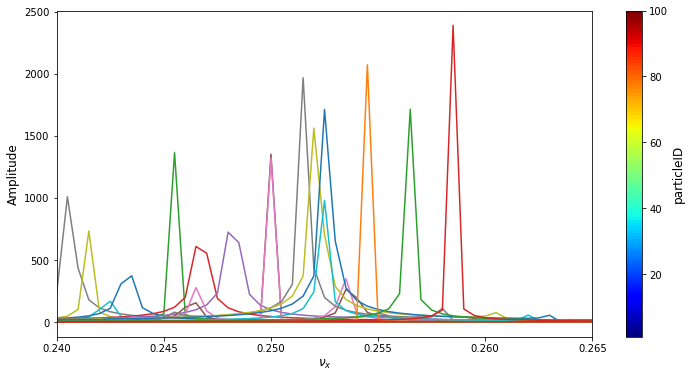

In [36]:
fig, ax = plt.subplots(figsize=(12,6))

n=100
cmap = mpl.cm.get_cmap('jet', n)

# colorbar setup
dummie_cax = ax.scatter(range(1,n+1), range(1,n+1), c=range(1,n+1), cmap=cmap)

freq = np.fft.fftfreq(2000)

for i, g in pdata.groupby("particleID"):
    df = g
    sp = np.fft.fft(df.x)
    ax.plot(freq,abs(sp.real))
    
plt.xlim(0.24,0.265)
plt.xlabel(r"$\nu_x$", fontsize=12)
plt.ylabel(r"Amplitude",fontsize=12)
cb =plt.colorbar(dummie_cax, label="ParticleID")
cb.set_label("particleID",fontsize=12)
# plt.savefig("FFT.png")

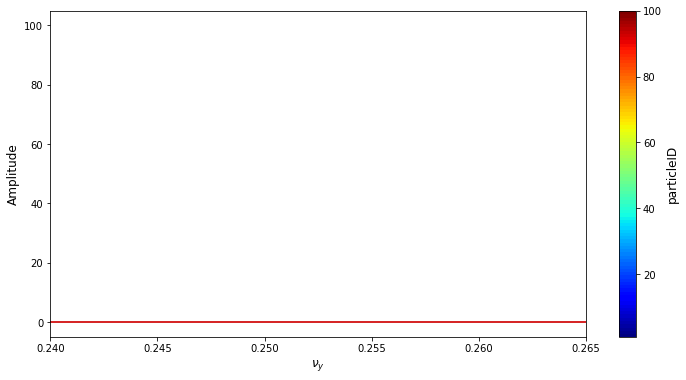

In [37]:
fig, ax = plt.subplots(figsize=(12,6))

n=100
cmap = mpl.cm.get_cmap('jet', n)

# colorbar setup
dummie_cax = ax.scatter(range(1,n+1), range(1,n+1), c=range(1,n+1), cmap=cmap)

freq = np.fft.fftfreq(2000)

for i, g in pdata.groupby("particleID"):
    df = g
    sp = np.fft.fft(df.y)
    ax.plot(freq,abs(sp.real))
    
plt.xlim(0.24,0.265)
plt.xlabel(r"$\nu_y$", fontsize=12)
plt.ylabel(r"Amplitude",fontsize=12)
cb =plt.colorbar(dummie_cax, label="ParticleID")
cb.set_label("particleID",fontsize=12)

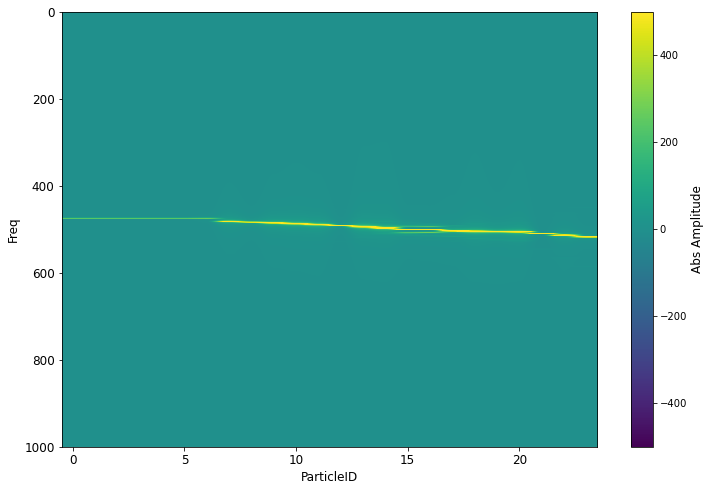

In [41]:
x = pdata.x.values.copy()
x = x.reshape(2000, 24)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=500, vmin=-500)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
# plt.ylim(6000,7000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("FreqWaterFall_zoomed.png")

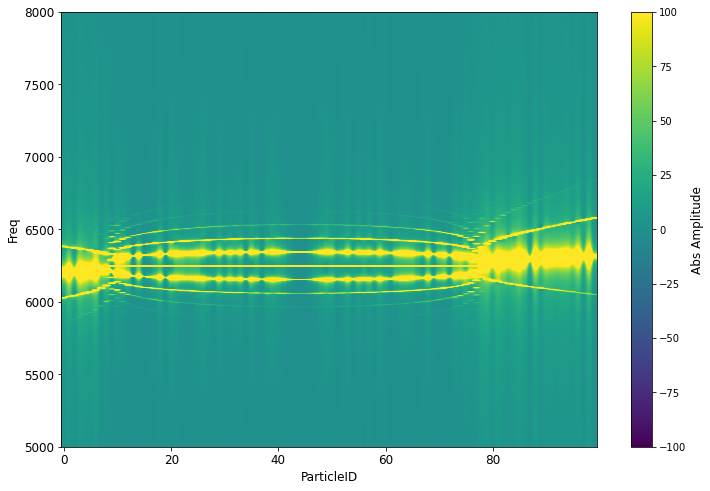

In [60]:
x = pdata.x.values.copy()
x = x.reshape(25000, 100)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=100, vmin=-100)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(5000,8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("FreqWaterFall.png")

(array([5000., 5500., 6000., 6500., 7000., 7500., 8000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

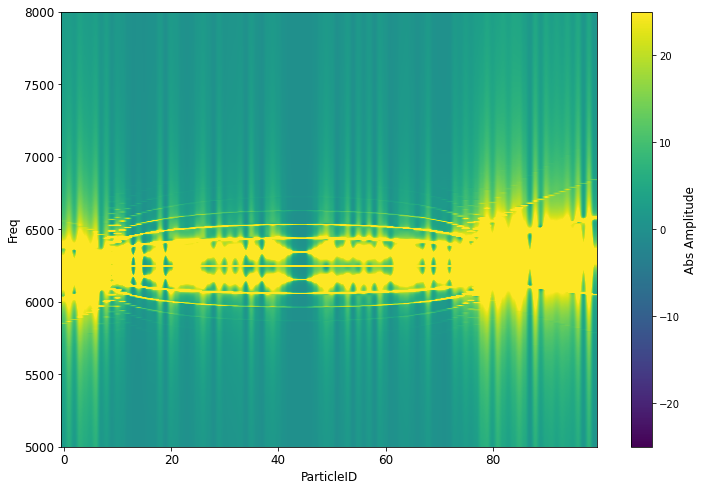

In [62]:
contrast = 25
x = pdata.x.values.copy()
x = x.reshape(25000, 100)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=contrast, vmin=-contrast)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(5000,8000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Compare with sixtracklib

In [21]:
elements ={
    "QF":{
        "type" : "QUADRUPOLE",
        "L": 0.342,
        "K1": 0.49,
#         "N_KICKS":16
    },
    "QD":{
        "type" : "QUADRUPOLE",
        "L": 0.668,
        "K1": -0.4999,
#         "N_KICKS":16
    },
    "D":{
        "type" : "DRIFT",
     "L":3.5805   
    },
}

FODOstr = "! FODO cell used by Jernej Frank for studying TRIBs\n\n"
stringlist = ["{:6}: {}".format(k,", ".join(["{}={:15.12f}".format(kk,vv) 
                                             if not isinstance(vv,str)
                                             else "{}={}".format(kk,vv)
                                             if kk!="type" else "{}".format(vv) for kk,vv in v.items()])) 
              for k,v in elements.items()]
line = ["QF","D","QD","D","QF"]
linestr = "{:6}: LINE=({})".format("FODO",",".join(line))
FODOstr += ";\n".join(stringlist)
FODOstr += ";\n\n"
FODOstr += linestr + ";"

print(FODOstr)

! FODO cell used by Jernej Frank for studying TRIBs

QF    : QUADRUPOLE, L= 0.342000000000, K1= 0.490000000000;
QD    : QUADRUPOLE, L= 0.668000000000, K1=-0.499900000000;
D     : DRIFT, L= 3.580500000000;

FODO  : LINE=(QF,D,QD,D,QF);


In [22]:
with open("FODO_Jernej_symplectic.madx","w") as f:
    f.write(FODOstr)

In [30]:
mad = Madx()
mad.options.echo = False
# mad.call(file="ap_test.madx")
# mad.call(file="fode_ap.seq")
mad.command.beam(particle='electron',energy=1.7,charge=1);
mad.call(file="FODO_Jernej_symplectic.madx")
mad.use(sequence="FODO")
twiss = mad.twiss()
q1mad = twiss.summary['q1']
q2mad = twiss.summary['q2']

print(q1mad, q2mad)

mad.command.select(flag="makethin", class_="quadrupole", slice='8')
# mad.command.select(flag="makethin", class_="sbend", slice='8')
mad.command.makethin(makedipedge=False, style="teapot", sequence="fodo")

mad.twiss()


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.01.20 16:41:15      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
             8.513                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.2357264166      -0.2898536485        14.01817743                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.2343324917 

               dq2            betymax              dymax              dyrms 
     -0.2892501119        13.31405343                 -0                  0 

            ycomax             ycorms             deltap 

<Table 'twiss': {name, keyword, s, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, l, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, k11l, k11sl, k12l, k12sl, k13l, k13sl, k14l, k14sl, k15l, k15sl, k16l, k16sl, k17l, k17sl, k18l, k18sl, k19l, k19sl, k20l, k20sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, v_pos, bbcharge, xma, yma, sigx, sigy, lrad, parent, comments, re11, re12, re13, re14, re15, re16, re21, re22, re23, re24, re25, re26, re31, re32, re33, re34, re35, re36, re41, re42, re43, re44, re45, re46, re51, re52, re53, re54, re55, re56, re61, re62, re63, re64, re65, re66, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, alfa

In [31]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
        mad.sequence.fodo, exact_drift=True, install_apertures=False
    )

In [34]:
# Build elements for SixTrackLib
elements = stl.Elements.from_line(pysixtrack_elements)
nturns = 25000

In [35]:
# add a bpm for storing turn by turn data
bpm = elements.BeamMonitor(num_stores=nturns)

In [38]:
from scipy import constants as const

In [41]:
const.physical_constants["electron mass energy equivalent in MeV"][0]*1e6

510998.94999999995

In [54]:
npart = 100

particles = stl.Particles.from_ref(
    npart, 
    mass0=const.physical_constants["electron mass energy equivalent in MeV"][0]*1e6,
    q0=-1,
    p0c=1.7e9)
particles.x += np.linspace(1.7,2.0,100)
# particles.px += np.array([0.05]*100)

In [55]:
job = stl.TrackJob(elements, particles)
job.track_until(nturns)

0

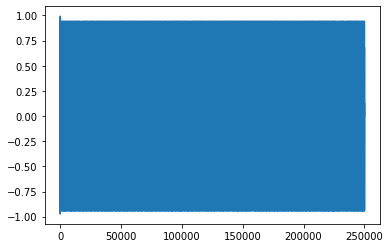

In [124]:
npart = 100

particles = stl.Particles.from_ref(npart,q0=-1, mass0=const.physical_constants["electron mass energy equivalent in MeV"][0]*1e6,p0c=1.7e9)
particles.x += np.linspace(0, 2, npart)
particles.px += np.array([0.05]*npart)
# particles.x += np.linspace(1.7,2.0, npart)
# job = stl.TrackJob(elements, particles, until_turn_elem_by_elem=2)
# job.track_elem_by_elem(1)
job = stl.TrackJob(elements, particles)
job.track_until(nturns)
plt.plot(job.output.particles[0].x[1::10])

In [107]:
job.output.particles[0].x.shape[1::10]

()

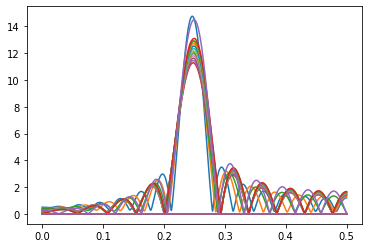

In [163]:
ff = np.linspace(0, 0.5, nturns // 2 + 1)

for i in range(35,npart):
    x = job.output.particles[0].x[i::npart]
    xf = abs(np.fft.rfft(x))
    plt.plot(ff, xf)
# plt.xlim(.24,.25)
# q1st = ff[xf.argmax()]
# print((q1mad - 20) - q1st)

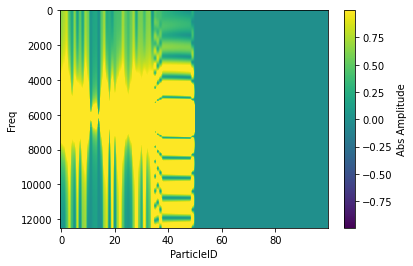

In [153]:
x = job.output.particles[0].x.copy()
x = x.reshape(nturns, npart)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())

# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID")
plt.ylabel("Freq")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude")
plt.savefig("sixtrack_freq_1.png")

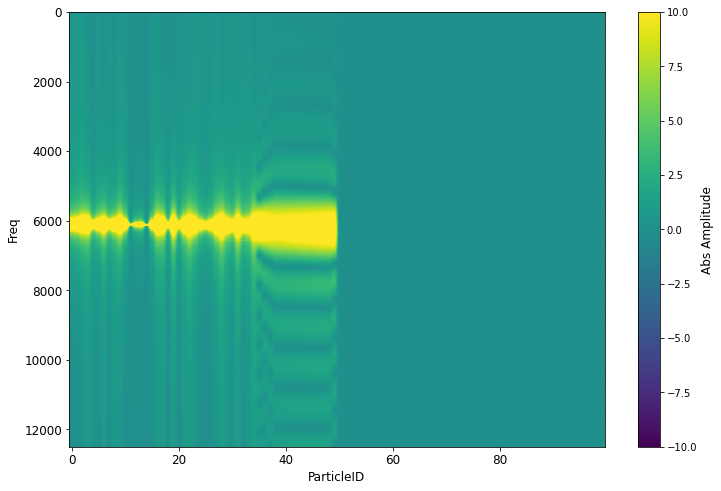

In [155]:
contrast = 10
x = job.output.particles[0].x.copy()
x = x.reshape(nturns, npart)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=contrast, vmin=-contrast)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
# plt.ylim(5000,8000)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig("sixtrack_freq_1.png")

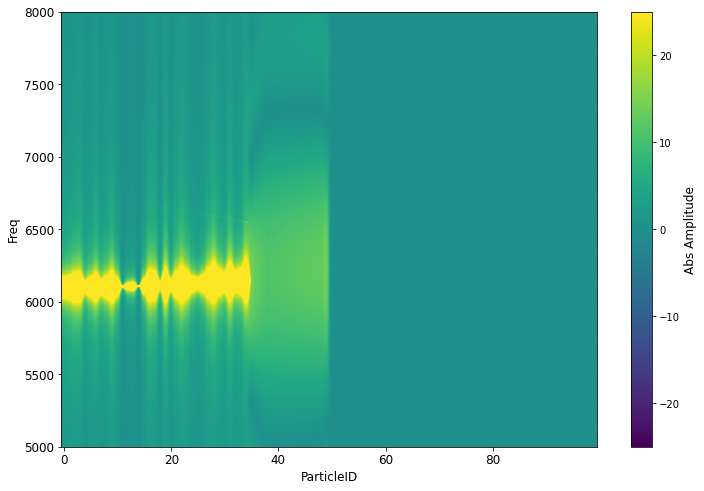

In [141]:
contrast = 25
x = job.output.particles[0].x.copy()
x = x.reshape(nturns, npart)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=contrast, vmin=-contrast)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(5000,8000)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

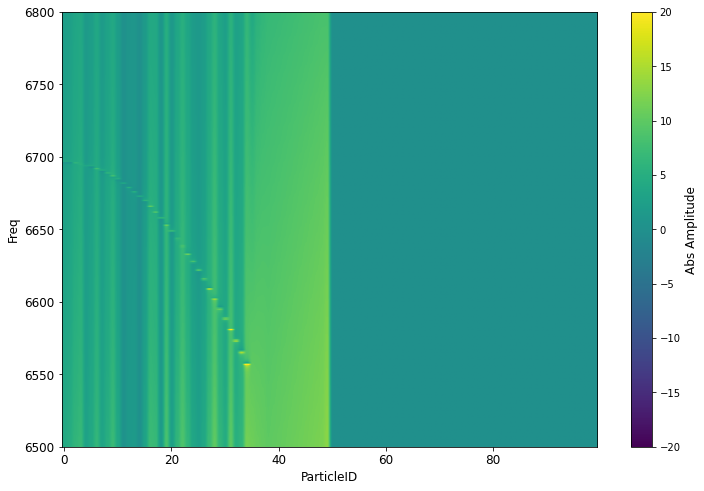

In [154]:
contrast = 20
x = job.output.particles[0].x.copy()
x = x.reshape(nturns, npart)
norm = plt.cm.colors.Normalize(vmax=x.max(), vmin=x.min())
norm = plt.cm.colors.Normalize(vmax=contrast, vmin=-contrast)

plt.figure(figsize=(12,8))
# be carefull - this is normalized to actual see a signal
plt.imshow(abs(np.fft.rfft(x, axis=0)),aspect="auto",norm=norm)
plt.xlabel("ParticleID",fontsize=12)
plt.ylabel("Freq",fontsize=12)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Abs Amplitude",fontsize=12)
plt.ylim(6500,6800)
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);
plt.savefig("sixtrack_freq_2.png")